# **Neural Network Implementation & Comparative Study**

**Aim:**
This project implements a scratch-built MLP, compares it with other models (Keras NN, XGBoost, Linear Regression, Random Forest), and analyzes architecture, optimizers, and robustness.

**Goals:**

* Implement a neural network from scratch using NumPy.
* Compare optimizers: SGD, Momentum, Adam.
* Study architecture depth & activation functions.
* Analyze robustness under noise and reduced training data.
* Benchmark vs Linear Regression, Random Forest, XGBoost, and Keras NN.

## **Formulas & Theory (Short Explanations)**

---

# **1. Forward Propagation**

$$Z^l = A^{l-1} W^l + b^l, \quad
A^l = \text{activation}(Z^l)
$$

**Purpose:** Compute the output of each layer. Activations introduce non-linearity so the network can model complex relationships.

**Common activations:**

- **ReLU:** $$\max(0, z)$$ → avoids vanishing gradient, fast to compute  
- **Tanh:** $$\tanh(z)$$ → outputs between -1 and 1, centered  
- **LeakyReLU:** $$z \text{ if } z>0, \text{ else } 0.01z$$ → allows small gradient for negative inputs

---

# **2. Loss Function**

$$L = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \lambda \sum_l \|W^l\|^2
$$

**Purpose:** Measures how far predictions are from true values. L2 regularization prevents overfitting by penalizing large weights.

---

# **3. Backpropagation**

**Output layer gradient:**

$$\delta^L = \frac{2}{n}(\hat{y} - y)
$$

**Hidden layer gradients:**

$$\delta^l = (\delta^{l+1} W^{l+1}) \odot \text{activation}'(Z^l)
$$

**Weight & bias gradients:**

$$\frac{\partial L}{\partial W^l} = (A^{l-1})^T \delta^l + \lambda W^l
$$

$$\frac{\partial L}{\partial b^l} = \sum \delta^l
$$

**Purpose:** Computes gradients of loss w.r.t. weights to update them for reducing error.

---

# **4. Optimizers**

**1. SGD:**  

$$W \leftarrow W - \eta \frac{\partial L}{\partial W}
$$  

- Simple step along negative gradient.  
- Can oscillate or be slow in valleys.

**2. Momentum:**  

$$v_t = \beta v_{t-1} + \eta \frac{\partial L}{\partial W}, \quad
W \leftarrow W - v_t
$$  

- Smooths updates using past gradients.  
- Faster convergence in consistent directions.

**3. Adam:**  

$$m_t = \beta_1 m_{t-1} + (1-\beta_1) \nabla W, \quad
v_t = \beta_2 v_{t-1} + (1-\beta_2)(\nabla W)^2
$$

$$\hat{m}_t = \frac{m_t}{1-\beta_1^t}, \quad
\hat{v}_t = \frac{v_t}{1-\beta_2^t}
$$

$$W \leftarrow W - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t}+\epsilon}
$$  

- Combines momentum + adaptive learning rate per weight.  
- Fast and stable convergence.

---

# **5. Evaluation Metrics**

- **MSE:** Average squared error  
- **RMSE:** Square root of MSE  
- **MAE:** Average absolute error  
- **R²:** Fraction of variance explained  

**Purpose:** Quantifies model performance and error.

---

# **6. Summary Workflow**

1. Forward pass → compute outputs  
2. Loss calculation → measure error  
3. Backprop → compute gradients  
4. Optimizer → update weights  
5. Repeat for all epochs → train model  
6. Evaluate → visualize predictions and residuals


**Imports & Setup**

In [ ]:
# Standard libraries
import os
import random
import math
import json
import warnings

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.datasets import fetch_california_housing, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Optional libraries
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    has_xgb = False

try:
    import tensorflow as tf
    from tensorflow import keras
    has_keras = True
except Exception:
    has_keras = False

# Suppress warnings
warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Install optional packages
!pip install -q xgboost

# Create directories for results and figures
os.makedirs("figures", exist_ok=True)
os.makedirs("results", exist_ok=True)

# Utility functions
def save_fig(fname):
    plt.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()

def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)

set_seed(SEED)

**Dataset & Preprocessing**

* Load California Housing dataset
* Visualize target distribution, scatter plots, correlation matrix
* Apply train/test split with feature scaling.

Dataset shape: (20640, 8)


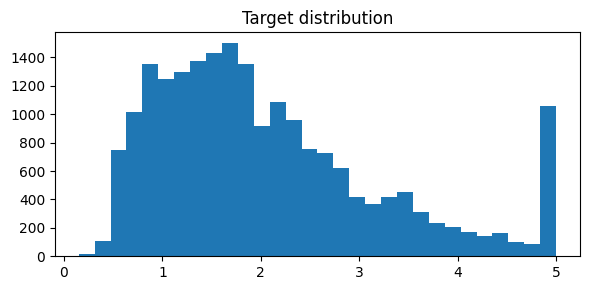

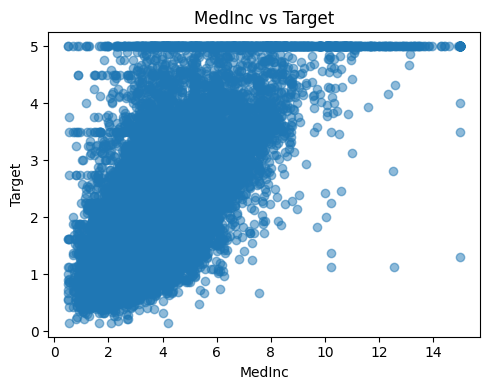

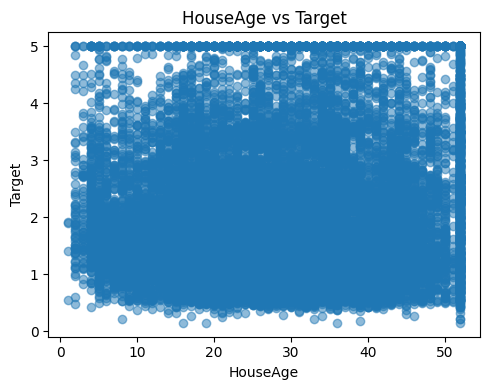

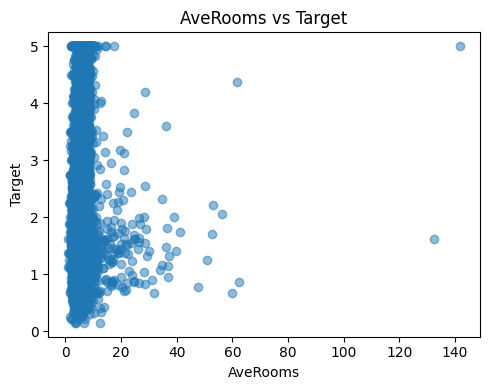

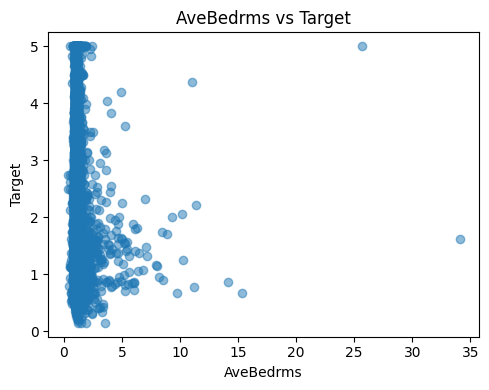

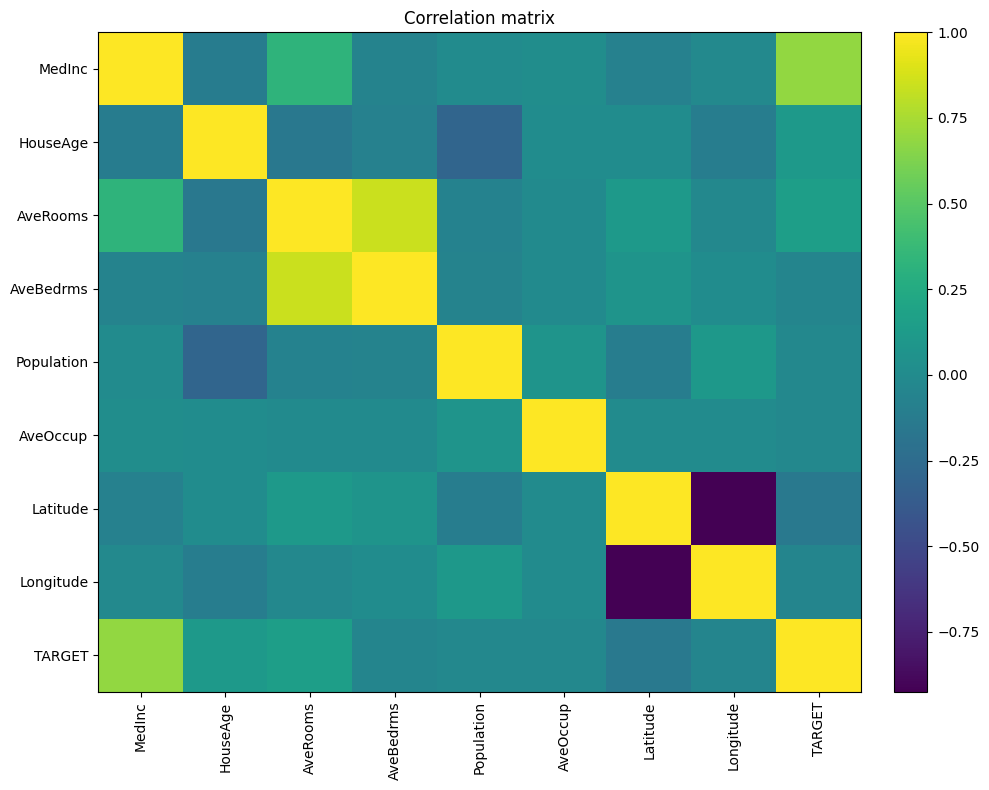

Train shape: (16512, 8) Test shape: (4128, 8)


In [ ]:
# Load California Housing dataset
cali = fetch_california_housing(as_frame=True)
X_df = cali.data
y = cali.target.values.reshape(-1,1)
feature_names = list(X_df.columns)
print("Dataset shape:", X_df.shape)

# --- Target distribution ---
plt.figure(figsize=(6,3))
plt.hist(y.ravel(), bins=30)
plt.title("Target distribution")
save_fig("figures/target_hist.png")

# --- Scatter plots for first 4 features ---
for col in feature_names[:4]:
    plt.figure(figsize=(5,4))
    plt.scatter(X_df[col].values, y.ravel(), alpha=0.5)
    plt.title(f"{col} vs Target")
    plt.xlabel(col)
    plt.ylabel("Target")
    save_fig(f"figures/scatter_{col}.png")

# --- Correlation matrix ---
df_corr = X_df.copy()
df_corr["TARGET"] = y.ravel()
corr = df_corr.corr()
plt.figure(figsize=(10,8))
plt.imshow(corr.values, aspect='auto')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Correlation matrix")
save_fig("figures/corr_matrix.png")

# --- Train/test split & feature scaling ---
X = X_df.values.astype(np.float64)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


**Neural Network From Scratch**


Defines a scratch-built MLP with configurable
* Hidden layers
* Activations (ReLU, Tanh, LeakyReLU)
* Optimizers (SGD, Momentum, Adam)
* L2 regularization
* Training/forward/backpropagation routines


In [ ]:
# --- Activation functions ---
def activation_fn(z, kind="relu"):
    if kind=="relu": return np.maximum(0,z)
    if kind=="tanh": return np.tanh(z)
    if kind=="leakyrelu": return np.where(z>0, z, 0.01*z)
    raise ValueError(kind)

def activation_deriv(z, kind="relu"):
    if kind=="relu": return (z>0).astype(float)
    if kind=="tanh": return 1 - np.tanh(z)**2
    if kind=="leakyrelu": return np.where(z>0, 1.0, 0.01)
    raise ValueError(kind)

# --- Scratch MLP Class ---
class ScratchMLP:
    def __init__(self, input_dim, hidden_layers, output_dim=1,
                 activation="relu", lr=0.01, epochs=200, batch_size=64,
                 optimizer="adam", l2=0.0, seed=42):
        np.random.seed(seed)
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.l2 = l2

        layer_dims = [input_dim] + hidden_layers + [output_dim]
        self.params = {}
        for i in range(1, len(layer_dims)):
            n_in, n_out = layer_dims[i-1], layer_dims[i]
            scale = np.sqrt(2.0/n_in) if activation in ("relu","leakyrelu") else np.sqrt(1.0/n_in)
            self.params[f"W{i}"] = np.random.randn(n_in, n_out) * scale
            self.params[f"b{i}"] = np.zeros((1, n_out))

        # optimizer state
        self.v = {k: np.zeros_like(v) for k,v in self.params.items()}
        self.m = {k: np.zeros_like(v) for k,v in self.params.items()}
        self.t = 0
        self.beta1, self.beta2, self.eps = 0.9, 0.999, 1e-8

    # --- Forward pass ---
    def forward(self, X):
        cache = {"A0": X}
        L = len([k for k in self.params if k.startswith("W")])
        for i in range(1, L):
            Z = cache[f"A{i-1}"] @ self.params[f"W{i}"] + self.params[f"b{i}"]
            cache[f"Z{i}"] = Z
            cache[f"A{i}"] = activation_fn(Z, self.activation)
        ZL = cache[f"A{L-1}"] @ self.params[f"W{L}"] + self.params[f"b{L}"]
        cache[f"Z{L}"] = ZL
        cache[f"A{L}"] = ZL  # Regression output
        return ZL, cache

    # --- Compute loss ---
    def compute_loss(self, y_true, y_pred):
        mse = np.mean((y_true - y_pred)**2)
        if self.l2 > 0:
            for k in self.params:
                if k.startswith("W"):
                    mse += self.l2 * np.sum(self.params[k]**2) / y_true.shape[0]
        return mse

    # --- Backpropagation ---
    def backward(self, cache, y_true, y_pred):
        grads = {}
        m = y_true.shape[0]
        L = len([k for k in self.params if k.startswith("W")])
        dA = (y_pred - y_true) * (2.0/m)
        grads[f"dW{L}"] = cache[f"A{L-1}"].T @ dA + self.l2 * self.params[f"W{L}"]
        grads[f"db{L}"] = np.sum(dA, axis=0, keepdims=True)
        dA_prev = dA @ self.params[f"W{L}"].T
        for i in range(L-1, 0, -1):
            dZ = dA_prev * activation_deriv(cache[f"Z{i}"], self.activation)
            grads[f"dW{i}"] = cache[f"A{i-1}"].T @ dZ + self.l2 * self.params[f"W{i}"]
            grads[f"db{i}"] = np.sum(dZ, axis=0, keepdims=True)
            if i > 1:
                dA_prev = dZ @ self.params[f"W{i}"].T
        return grads

    # --- Parameter update step ---
    def step(self, grads):
        self.t += 1
        for k in self.params:
            gk = grads["d"+k]
            if self.optimizer=="sgd":
                self.params[k] -= self.lr * gk
            elif self.optimizer=="momentum":
                self.v[k] = self.beta1*self.v[k] + self.lr*gk
                self.params[k] -= self.v[k]
            elif self.optimizer=="adam":
                self.m[k] = self.beta1*self.m[k] + (1-self.beta1)*gk
                self.v[k] = self.beta2*self.v[k] + (1-self.beta2)*(gk**2)
                m_hat = self.m[k] / (1-self.beta1**self.t)
                v_hat = self.v[k] / (1-self.beta2**self.t)
                self.params[k] -= self.lr * m_hat / (np.sqrt(v_hat)+self.eps)

    # --- Fit model ---
    def fit(self, X, y, X_val=None, y_val=None):
        n = X.shape[0]
        history = {"train_loss": [], "val_loss": []}
        for epoch in range(self.epochs):
            idx = np.arange(n)
            np.random.shuffle(idx)
            X, y = X[idx], y[idx]
            for start in range(0,n,self.batch_size):
                end = start+self.batch_size
                xb, yb = X[start:end], y[start:end]
                y_pred, cache = self.forward(xb)
                grads = self.backward(cache, yb, y_pred)
                self.step(grads)
            y_pred_train,_ = self.forward(X)
            loss_train = self.compute_loss(y, y_pred_train)
            history["train_loss"].append(loss_train)
            if X_val is not None:
                y_pred_val,_ = self.forward(X_val)
                loss_val = self.compute_loss(y_val, y_pred_val)
                history["val_loss"].append(loss_val)
            if (epoch+1)%50==0:
                print(f"Epoch {epoch+1}/{self.epochs} - train loss: {loss_train:.4f}")
        return history

    # --- Predict ---
    def predict(self,X):
        y_pred,_ = self.forward(X)
        return y_pred


**Experiments:**

This trains the scratch-built neural network, evaluates it with standard metrics, trains baseline models (Keras NN and XGBoost), and visualizes performance comparisons and error analysis.

Epoch 50/300 - train loss: 0.2535
Epoch 100/300 - train loss: 0.2310
Epoch 150/300 - train loss: 0.2187
Epoch 200/300 - train loss: 0.2291
Epoch 250/300 - train loss: 0.2340
Epoch 300/300 - train loss: 0.2073


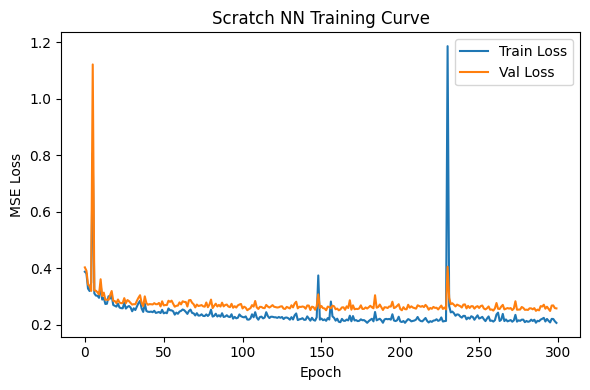

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


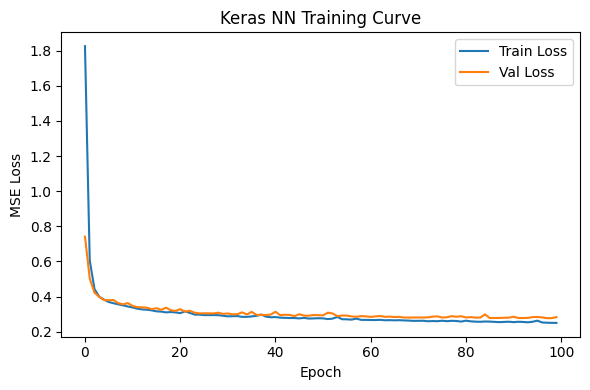

        model       MSE      RMSE       MAE        R2
0  Scratch NN  0.258559  0.508487  0.340148  0.802689
1    Keras NN  0.283315  0.532273  0.357476  0.783797
2     XGBoost  0.206728  0.454674  0.294160  0.842242


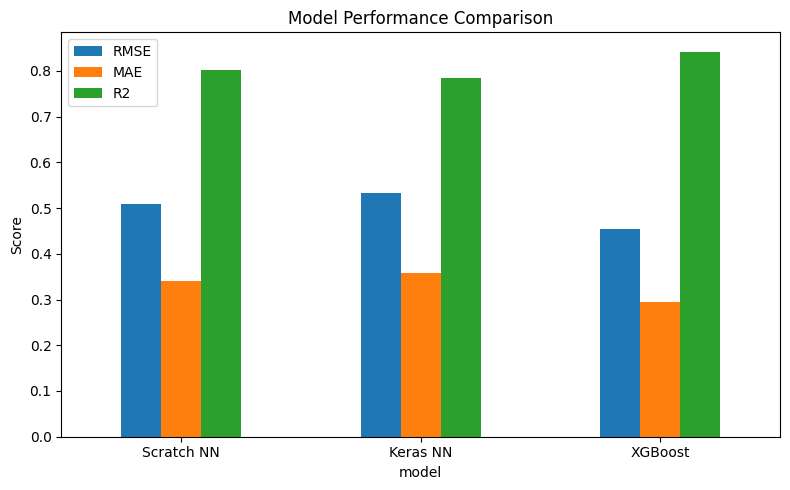

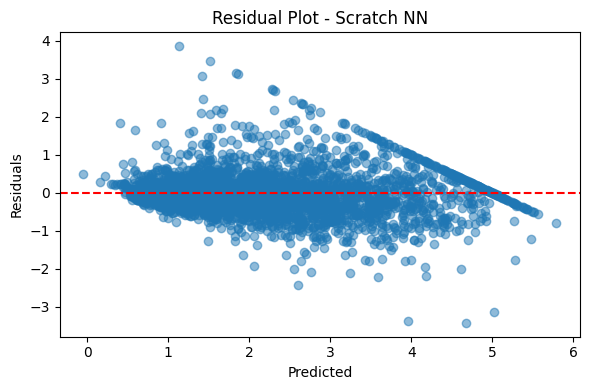

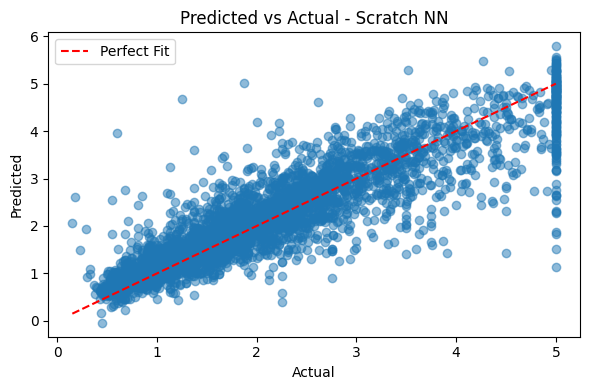

In [ ]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- Helper function for evaluation ---
def evaluate_model(y_true, y_pred, name="model"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"model": name, "MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

results = []

# --- 5.1 Train Scratch Neural Network ---
scratch_model = ScratchMLP(
    input_dim=X_train.shape[1],
    hidden_layers=[64,32],
    activation="relu",
    optimizer="adam",
    lr=0.01,
    epochs=300,
    batch_size=128,
    l2=1e-4
)

history = scratch_model.fit(X_train, y_train, X_val=X_test, y_val=y_test)

# Plot training/validation loss
plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
plt.title("Scratch NN Training Curve")
save_fig("figures/scratch_nn_loss.png")

# Predictions
y_pred_scratch = scratch_model.predict(X_test)
results.append(evaluate_model(y_test, y_pred_scratch, "Scratch NN"))

# --- 5.2 Keras NN Baseline ---
import tensorflow as tf
from tensorflow import keras

keras_model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1)
])

keras_model.compile(optimizer="adam", loss="mse")
history_keras = keras_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100, batch_size=128, verbose=0
)

y_pred_keras = keras_model.predict(X_test)
results.append(evaluate_model(y_test, y_pred_keras, "Keras NN"))

plt.figure(figsize=(6,4))
plt.plot(history_keras.history["loss"], label="Train Loss")
plt.plot(history_keras.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
plt.title("Keras NN Training Curve")
save_fig("figures/keras_nn_loss.png")

# --- 5.3 XGBoost Baseline ---
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=300, learning_rate=0.1, max_depth=6, subsample=0.8, random_state=42
)
xgb_model.fit(X_train, y_train.ravel())
y_pred_xgb = xgb_model.predict(X_test)
results.append(evaluate_model(y_test, y_pred_xgb, "XGBoost"))

# --- 5.4 Collect & Save Results ---
df_results = pd.DataFrame(results)
print(df_results)
df_results.to_csv("results/metrics_summary.csv", index=False)

# --- 5.5 Visualization: Bar Plot ---
df_plot = df_results.set_index("model")[["RMSE","MAE","R2"]]
df_plot.plot(kind="bar", figsize=(8,5), rot=0)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
save_fig("figures/model_comparison.png")

# --- 5.6 Error Analysis: Scratch NN ---
# Residual plot
residuals = y_test - y_pred_scratch
plt.figure(figsize=(6,4))
plt.scatter(y_pred_scratch, residuals, alpha=0.5)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")
plt.title("Residual Plot - Scratch NN")
save_fig("figures/scratch_nn_residuals.png")

# Predicted vs Actual
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_scratch, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--", label="Perfect Fit")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.legend()
plt.title("Predicted vs Actual - Scratch NN")
save_fig("figures/scratch_nn_pred_vs_actual.png")
